In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pyramid-arima
from pyramid.arima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

     |████████████████████████████████| 597 kB 291 kB/s eta 0:00:01


In [2]:
df = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
set(df['Country/Region'])

{' Azerbaijan',
 "('St. Martin',)",
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'F

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
SNo                306429 non-null int64
ObservationDate    306429 non-null object
Province/State     228329 non-null object
Country/Region     306429 non-null object
Last Update        306429 non-null object
Confirmed          306429 non-null float64
Deaths             306429 non-null float64
Recovered          306429 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [5]:
#Dropping sno column
df.drop(["SNo"],1,inplace=True)

In [6]:
# convert to datetime format
df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])

In [7]:
# get US data
data_us_all = df[df["Country/Region"]=="US"]
data_us = data_us_all.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(data_us.iloc[-1])
print("Total Active Cases: ",data_us["Confirmed"].iloc[-1]-data_us["Recovered"].iloc[-1]-data_us["Deaths"].iloc[-1])
print("Total Closed Cases: ",data_us["Recovered"].iloc[-1]+data_us["Deaths"].iloc[-1])

Confirmed    33251939.0
Recovered           0.0
Deaths         594306.0
Name: 2021-05-29 00:00:00, dtype: float64
Total Active Cases:  32657633.0
Total Closed Cases:  594306.0


In [8]:
data_us_all.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
31,2020-01-22,Washington,US,1/22/2020 17:00,1.0,0.0,0.0
71,2020-01-23,Washington,US,1/23/20 17:00,1.0,0.0,0.0
121,2020-01-24,Washington,US,1/24/20 17:00,1.0,0.0,0.0
122,2020-01-24,Chicago,US,1/24/20 17:00,1.0,0.0,0.0
164,2020-01-25,Washington,US,1/25/20 17:00,1.0,0.0,0.0


In [9]:
data_us_all.tail()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
306395,2021-05-29,Virginia,US,2021-05-30 04:20:55,675165.0,11160.0,0.0
306405,2021-05-29,Washington,US,2021-05-30 04:20:55,435849.0,5765.0,0.0
306408,2021-05-29,West Virginia,US,2021-05-30 04:20:55,161287.0,2792.0,0.0
306410,2021-05-29,Wisconsin,US,2021-05-30 04:20:55,674003.0,7830.0,0.0
306411,2021-05-29,Wyoming,US,2021-05-30 04:20:55,60144.0,719.0,0.0


In [10]:
data_us["Days Since"]=data_us.index-data_us.index[0]
data_us["Days Since"]=data_us["Days Since"].dt.days

In [11]:
data_us.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,1.0,0.0,0.0,0
2020-01-23,1.0,0.0,0.0,1
2020-01-24,2.0,0.0,0.0,2
2020-01-25,2.0,0.0,0.0,3
2020-01-26,5.0,0.0,0.0,4


In [12]:
data_us.tail()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2021-05-25,33166418.0,0.0,590941.0,489
2021-05-26,33190470.0,0.0,591950.0,490
2021-05-27,33217995.0,0.0,593288.0,491
2021-05-28,33239963.0,0.0,593963.0,492
2021-05-29,33251939.0,0.0,594306.0,493


In [13]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases', line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Deaths"],
                    mode='lines+markers',
                    name='Death Cases', line=dict(color='crimson')))
fig.update_layout(title="US Cases growth",
                 xaxis_title="Date",yaxis_title="#Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## ML prediction

#### Linear Regression Model for Confirm Cases

In [14]:
# train-valid split
train_split = data_us.iloc[:int(data_us.shape[0]*0.85)]
valid_split = data_us.iloc[int(data_us.shape[0]*0.85):]
train_split_x = np.array(train_split["Days Since"]).reshape(-1,1)
train_split_y = np.array(train_split["Confirmed"]).reshape(-1,1)
valid_split_x = np.array(valid_split["Days Since"]).reshape(-1,1)
valid_split_y = np.array(valid_split["Confirmed"]).reshape(-1,1)
model_scores=[]

In [15]:
linear_regression = LinearRegression(normalize=True)

In [16]:
# train
linear_regression.fit(train_split_x, train_split_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [17]:
# predict on validation set
linear_regression_pred_valid = linear_regression.predict(valid_split_x)

In [18]:
model_scores.append(np.sqrt(mean_squared_error(valid_split_y, linear_regression_pred_valid)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_split_y, linear_regression_pred_valid)))

Root Mean Square Error for Linear Regression:  5235776.737476195


In [19]:
plt.figure(figsize=(11,6))
linear_regression_pred =linear_regression.predict(np.array(data_us["Days Since"]).reshape(-1,1))
linear_regression_out =[]
for i in range(linear_regression_pred.shape[0]):
    linear_regression_out.append(linear_regression_pred[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',name="Data", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=linear_regression_out,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### Polynomial Regression for Prediction of Confirmed Cases

In [20]:
polynomial_features = PolynomialFeatures(degree = 4) 

In [21]:
train_split_poly = polynomial_features.fit_transform(train_split_x)
valid_split_poly = polynomial_features.fit_transform(valid_split_x)

In [22]:
polynomial_regression = LinearRegression(normalize=True)
polynomial_regression.fit(train_split_poly, train_split["Confirmed"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [23]:
polynomial_regression_pred_valid = polynomial_regression.predict(valid_split_poly)
polynomial_regression_rmse = np.sqrt(mean_squared_error(valid_split["Confirmed"], polynomial_regression_pred_valid))
model_scores.append(polynomial_regression_rmse)
print("Root Mean Squared Error for Polynomial Regression: ",polynomial_regression_rmse)

Root Mean Squared Error for Polynomial Regression:  8124996.200146888


In [24]:
polynomial_regression_pred = polynomial_regression.predict(polynomial_features.fit_transform(np.array(data_us["Days Since"]).reshape(-1,1)))
plt.figure(figsize=(11,6))
fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',name="Data", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=polynomial_regression_pred,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### Polynomial Ridge Regression 

In [25]:
polynomial_features = PolynomialFeatures(degree = 4) 
train_split_poly = polynomial_features.fit_transform(train_split_x)
valid_split_poly = polynomial_features.fit_transform(valid_split_x)

In [26]:
polynomial_ridge_regression = Ridge(normalize=True)
polynomial_ridge_regression.fit(train_split_poly, train_split["Confirmed"])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [27]:
polynomial_ridge_regression_pred_valid = polynomial_ridge_regression.predict(valid_split_poly)
polynomial_ridge_regression_rmse = np.sqrt(mean_squared_error(valid_split["Confirmed"], polynomial_ridge_regression_pred_valid))
model_scores.append(polynomial_ridge_regression_rmse)
print("Root Mean Squared Error for Polynomial Ridge Regression: ",polynomial_ridge_regression_rmse)

Root Mean Squared Error for Polynomial Ridge Regression:  4155186.3308604336


In [117]:
# degree 3
# polynomial_ridge_regression_pred = polynomial_ridge_regression.predict(polynomial_features.fit_transform(np.array(data_us["Days Since"]).reshape(-1,1)))
# plt.figure(figsize=(11,6))
# fig=go.Figure()
# fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
#                     mode='lines+markers',name="Data", line=dict(color='cornflowerblue')))
# fig.add_trace(go.Scatter(x=data_us.index, y=polynomial_ridge_regression_pred,
#                     mode='lines',name="Polynomial Ridge Regression Best Fit",
#                     line=dict(color='black', dash='dot')))
# fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
#                  xaxis_title="Date",yaxis_title="Confirmed Cases",
#                  legend=dict(x=0,y=1,traceorder="normal"))
# fig.show()

<Figure size 792x432 with 0 Axes>

In [28]:
polynomial_ridge_regression_pred = polynomial_ridge_regression.predict(polynomial_features.fit_transform(np.array(data_us["Days Since"]).reshape(-1,1)))
plt.figure(figsize=(11,6))
fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',name="Data", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=polynomial_ridge_regression_pred,
                    mode='lines',name="Polynomial Ridge Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [29]:
import xgboost as xgb

In [30]:
model_xgb = xgb.XGBRegressor(objective ='reg:linear')

In [31]:
model_xgb.fit(train_split_x, train_split_y)

[23:37:03] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [32]:
xgb_pred_valid = model_xgb.predict(valid_split_x)
xgb_pred_rmse = np.sqrt(mean_squared_error(valid_split["Confirmed"], xgb_pred_valid))
model_scores.append(xgb_pred_rmse)
print("Root Mean Squared Error for Polynomial Ridge Regression: ", xgb_pred_rmse)

Root Mean Squared Error for Polynomial Ridge Regression:  2501311.406933419


In [34]:
xgb_pred_valid

array([29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524., 29489524., 29489524., 29489524.,
       29489524., 29489524., 29489524.], dtype=float32)

In [35]:
xgb_pred = model_xgb.predict(np.array(data_us["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))

fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=xgb_pred,
                    mode='lines',name="XGB Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases XGB Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### SVR

In [33]:
svm = SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [34]:
svm.fit(train_split_x, train_split_y)

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [35]:
# predict on validation set
svm_pred_valid = svm.predict(valid_split_x)

In [36]:
model_scores.append(np.sqrt(mean_squared_error(valid_split_y, svm_pred_valid)))
print("Root Mean Square Error for SVM: ",np.sqrt(mean_squared_error(valid_split_y, svm_pred_valid)))

Root Mean Square Error for SVM:  39460317.2882337


In [38]:
svm_pred = svm.predict(np.array(data_us["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
fig=go.Figure()
fig.add_trace(go.Scatter(x=data_us.index, y=data_us["Confirmed"],
                    mode='lines+markers',name="Data", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=data_us.index, y=svm_pred,
                    mode='lines',name="Support Vector Machine Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vector Machine Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

## Time Series Forecasting 

### AUTO ARIMA model

In [39]:
arima = auto_arima(train_split["Confirmed"], trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True, stepwise=False, seasonal=False)
arima.fit(train_split["Confirmed"])

Fit ARIMA: order=(1, 2, 1); AIC=9287.380, BIC=9303.512, Fit time=0.071 seconds
Fit ARIMA: order=(1, 2, 2); AIC=9289.348, BIC=9309.514, Fit time=0.158 seconds
Fit ARIMA: order=(1, 2, 3); AIC=9291.324, BIC=9315.523, Fit time=0.177 seconds
Fit ARIMA: order=(2, 2, 1); AIC=9289.317, BIC=9309.482, Fit time=0.079 seconds
Fit ARIMA: order=(2, 2, 2); AIC=9261.032, BIC=9285.230, Fit time=0.185 seconds
Fit ARIMA: order=(2, 2, 3); AIC=9259.473, BIC=9287.705, Fit time=0.270 seconds
Fit ARIMA: order=(3, 2, 1); AIC=9289.994, BIC=9314.193, Fit time=0.114 seconds
Fit ARIMA: order=(3, 2, 2); AIC=9223.873, BIC=9252.105, Fit time=0.289 seconds
Fit ARIMA: order=(3, 2, 3); AIC=9264.699, BIC=9296.964, Fit time=0.385 seconds
Total fit time: 1.741 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 2, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend='c')

In [40]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  417
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -4604.937
Method:                       css-mle   S.D. of innovations          15080.819
Date:                Wed, 14 Dec 2022   AIC                           9223.873
Time:                        23:37:49   BIC                           9252.105
Sample:                             2   HQIC                          9235.035
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        135.8896    401.308      0.339      0.735    -650.659     922.438
ar.L1.D2.y     0.7627      0.048     16.023      0.000       0.669       0.856
ar.L2.D2.y    -0.3708      0.055     -6.712      0.000      -0.479      -0.263
ar.L3.D2.y    -0.4432      0.046     -9.540      0.000      -0.534      -0.352
ma.L1.D2.y    -1.3434      0.026    -52.035      0.000      -1.394      -1.293
ma.L2.D2.y     0.9140      0.023     39.541      0.000       0.869       0.959
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6499           -0.7961j            1.0277           -0.1410
AR.2            0.6499           +0.7961j            1.0277            0.1410
AR.3           -2.1365           -0.0000j            2.1365           -0.5000
MA.1            0.7348           -0.7443j            1.0460           -0.1260
MA.2            0.7348           +0.7443j            1.0460            0.1260
-----------------------------------------------------------------------------
"""

In [41]:
# predict on validation set
arima_pred_valid = arima.predict(len(valid_split))

In [42]:
model_scores.append(np.sqrt(mean_squared_error(valid_split["Confirmed"], arima_pred_valid)))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(valid_split["Confirmed"], arima_pred_valid)))

Root Mean Square Error for AR Model:  271012.7699614097


In [45]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_split.index, y=train_split["Confirmed"],
                    mode='lines+markers',name="training dataset", line=dict(color='cornflowerblue')))
fig.add_trace(go.Scatter(x=valid_split.index, y=valid_split["Confirmed"],
                    mode='lines+markers',name="validation dataset",))
fig.add_trace(go.Scatter(x=valid_split.index, y=arima_pred_valid,
                    mode='lines+markers',name="validation prediction",))
fig.update_layout(title="Auto ARIMA Model Prediction for Confirmed cases",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### Model Prediction Summary

In [43]:
model_names=["Linear Regression","Polynomial Regression", "Polynomial Ridge Regression", 'XGBoost', 'SVM', "ARIMA Model"]
model_summary=pd.DataFrame(zip(model_names, model_scores), columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
5,ARIMA Model,2.710128e+05
3,XGBoost,2.501311e+06
2,Polynomial Ridge Regression,4.155186e+06
0,Linear Regression,5.235777e+06
1,Polynomial Regression,8.124996e+06
4,SVM,3.946032e+07


### Time Series Forecasting for Death Cases

In [44]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_split.index, y=train_split["Deaths"],
                    mode='lines+markers',name="Death Cases", line=dict(color='red')))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="#Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [48]:
# train-valid split
train_split_death = data_us.iloc[:int(data_us.shape[0]*0.85)]
valid_split_death = data_us.iloc[int(data_us.shape[0]*0.85):]
# train_split_x = np.array(train_split["Days Since"]).reshape(-1,1)
# train_split_y = np.array(train_split["Death"]).reshape(-1,1)
# valid_split_x = np.array(valid_split["Days Since"]).reshape(-1,1)
# valid_split_y = np.array(valid_split["Confirmed"]).reshape(-1,1)
# model_scores=[]

In [49]:
arima_death = auto_arima(train_split_death["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=4,max_q=4,suppress_warnings=True,stepwise=False,seasonal=False)     
arima_death.fit(train_split_death["Deaths"])

Fit ARIMA: order=(0, 2, 0); AIC=6396.037, BIC=6404.103, Fit time=0.006 seconds
Fit ARIMA: order=(0, 2, 1); AIC=6392.525, BIC=6404.624, Fit time=0.049 seconds
Fit ARIMA: order=(0, 2, 2); AIC=6312.865, BIC=6328.998, Fit time=0.093 seconds
Fit ARIMA: order=(0, 2, 3); AIC=6287.441, BIC=6307.606, Fit time=0.131 seconds
Fit ARIMA: order=(0, 2, 4); AIC=6278.770, BIC=6302.968, Fit time=0.207 seconds
Fit ARIMA: order=(1, 2, 0); AIC=6394.764, BIC=6406.863, Fit time=0.016 seconds
Fit ARIMA: order=(1, 2, 1); AIC=6340.343, BIC=6356.476, Fit time=0.118 seconds
Fit ARIMA: order=(1, 2, 2); AIC=6300.343, BIC=6320.509, Fit time=0.130 seconds
Fit ARIMA: order=(1, 2, 3); AIC=6288.086, BIC=6312.284, Fit time=0.332 seconds
Fit ARIMA: order=(1, 2, 4); AIC=6239.946, BIC=6268.177, Fit time=0.305 seconds
Fit ARIMA: order=(2, 2, 0); AIC=6370.414, BIC=6386.546, Fit time=0.047 seconds
Fit ARIMA: order=(2, 2, 1); AIC=6260.268, BIC=6280.433, Fit time=0.098 seconds
Fit ARIMA: order=(2, 2, 2); AIC=6155.198, BIC=6179.3

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(4, 2, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend='c')

In [50]:
preds_deaths = arima_death.predict(len(valid_split_death))

In [51]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid_split_death["Deaths"],preds_deaths)))

Root Mean Square Error:  19395.362137250373


In [53]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_split_death.index, y=train_split_death["Deaths"],
                    mode='lines+markers',name="training data "))
fig.add_trace(go.Scatter(x=valid_split_death.index, y=valid_split_death["Deaths"],
                    mode='lines+markers',name="validation data",))
fig.add_trace(go.Scatter(x=valid_split_death.index, y=preds_deaths,
                    mode='lines+markers',name="ARIMA prediction",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [59]:
dates = []
arima_death_preds_5 =[]
for i in range(1,18):
    dates.append(data_us.index[-1]+timedelta(days=i))
    arima_death_preds_5.append(arima_death.predict(len(valid_split_death)+i)[-1])

In [60]:
pd.DataFrame(zip(dates,arima_death_preds_5),columns=["Deaths","ARIMA Model Death Prediction"]).head()

,Deaths,ARIMA Model Death Prediction
0,2021-05-30,634398.102171
1,2021-05-31,635665.736319
2,2021-06-01,637039.838346
3,2021-06-02,638529.354484
4,2021-06-03,640059.913356


## Conclusion

COVID-19 doesn't have very high mortatlity rate as we can see which is the most positive take away. Also the healthy Recovery Rate implies the disease is cureable. The only matter of concern is the exponential growth rate of infection. 

Countries like USA, Spain, United Kingdom,and Italy are facing some serious trouble in containing the disease showing how deadly the neglegence can lead to. The need of the hour is to perform COVID-19 pendemic controlling practices like Testing, Contact Tracing and Quarantine with a speed greater than the speed of disease spread at each country level.

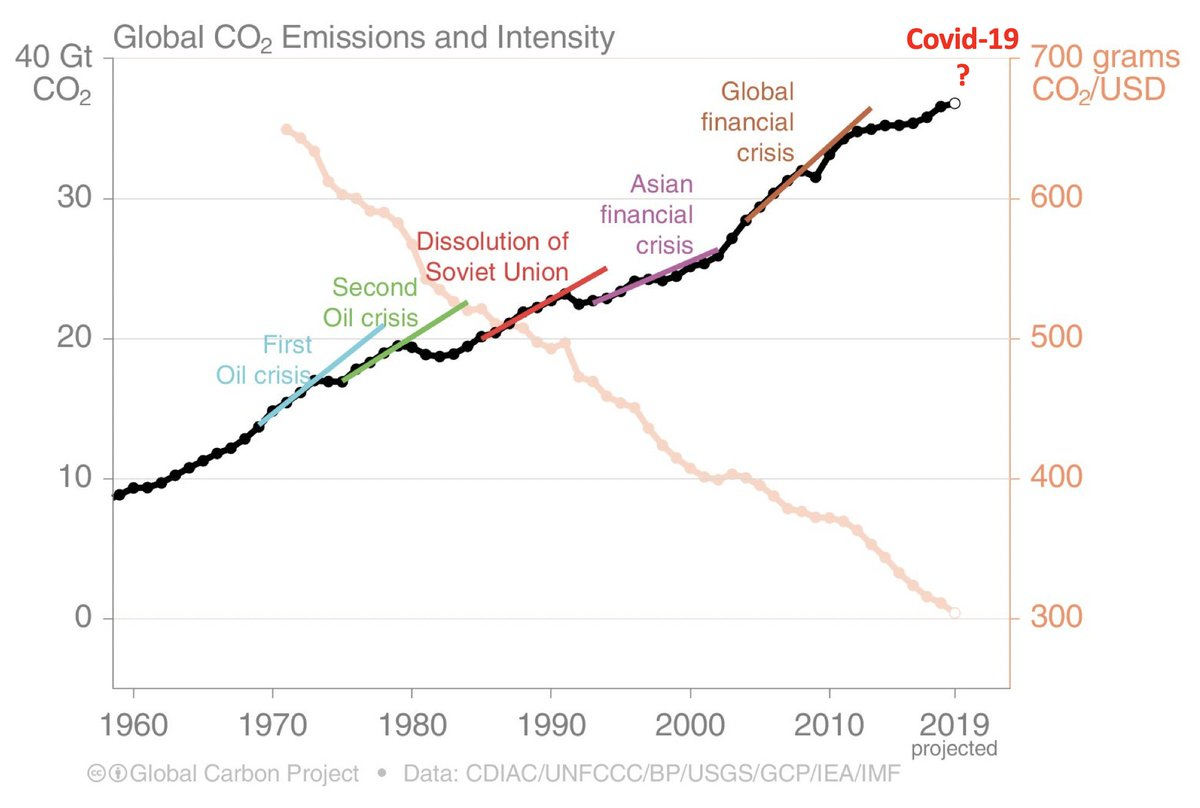

The reason of putting this graph in the conclusion, there is an interesting pattern to observe here, Everytime there has been drop in World's Carbon emission, the world economy crashed. A one classic example is 2008 recession. I think most of you must have already guessed what's ahead, probably COVID-19 is just a big wave with a Tsunami of Recession or Depression following it. 

The growth of Confirmed and Death Cases seems to have slowed down since past few days. Which is really good sign. Hope this goes like that for a brief period. There should not be any new country emerging as the new epicenter of COVID-19 just like USA happened to be that epicenter for brief period. In case if any new country emerges as new epicenter, the Growth of Confirmed Cases will shoot up again.

### Will be updating the notebook with new Data Visualization Plot and new Prediction and Forecasting Models. Please upvote the kernel if you have liked the work. Also, any kind of suggestion and corrections would be highly appreciated!

## Stay Safe and follow basic hygiene Practices!